In [343]:
from dottamine import dotim
import numpy as np
import skimage as sk
from skimage.morphology import convex_hull_image
import cv2
from scipy.ndimage import center_of_mass, rotate, gaussian_filter, zoom, binary_closing, binary_opening, distance_transform_edt, binary_dilation, binary_erosion, generate_binary_structure
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from copy import copy

In [37]:
image = sk.io.imread('./../ppujol/DomesN2V/62_denoised.tif')
image = np.transpose(image[2], axes=(1, 0, 2))
image = np.transpose(image, axes=(2, 1, 0))

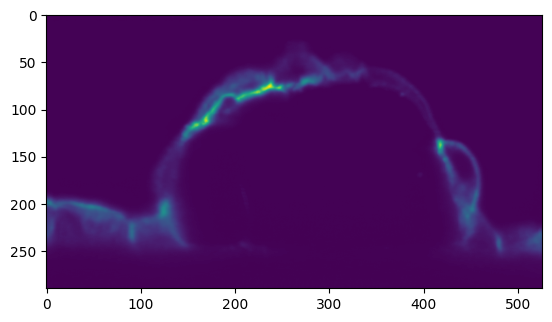

In [667]:
plt.imshow(image[200])

In [584]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

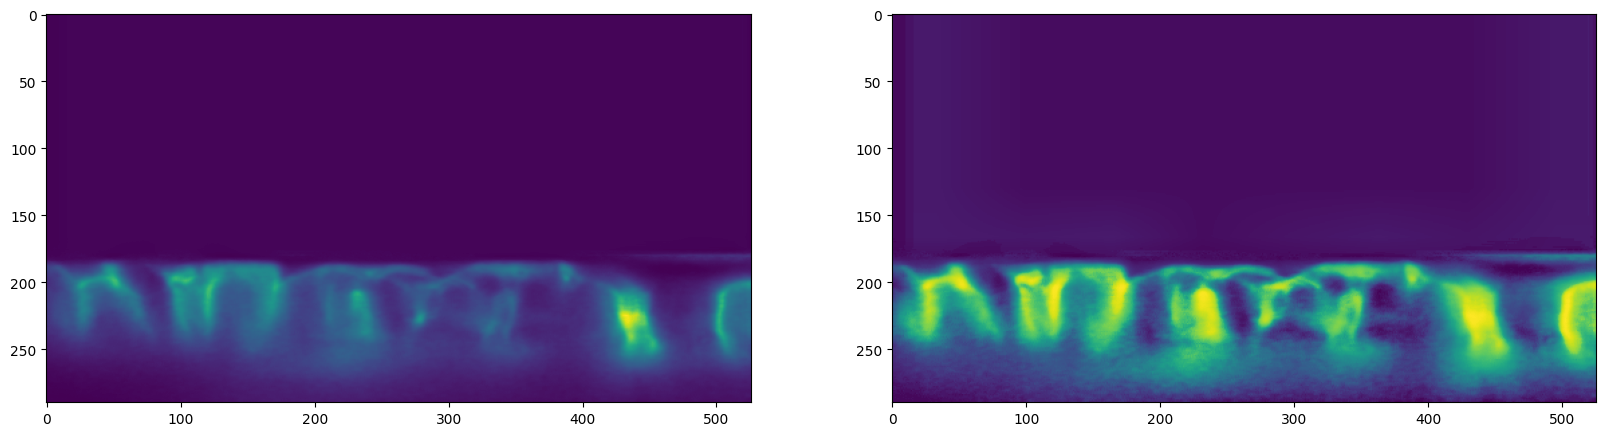

In [743]:
y = 20
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
cl1 = clahe.apply(normalize_image(image[y], 255).astype(np.uint8))
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image[y])
plt.subplot(122)
plt.imshow(cl1)

In [817]:
# Reshape the 3D volume into a 1D array
flat_image = image.flatten()

# Apply histogram equalization to the 1D array
clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8))
cl1 = clahe.apply(normalize_image(flat_image, 255).astype(np.uint8))

# Reshape the equalized 1D array back to the original 3D shape
clahe_image = cl1.reshape(image.shape)

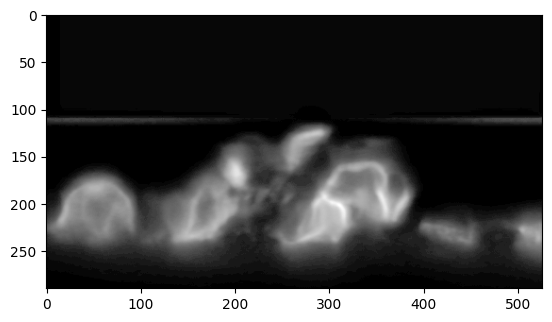

In [767]:
plt.imshow(clahe_image[90], cmap='grey')

In [645]:
# Reshape the 3D volume into a 1D array
flat_image = image.flatten()

# Apply histogram equalization to the 1D array
equalized_flat_volume = cv2.equalizeHist(normalize_image(flat_image, 255).astype(np.uint8))

# Reshape the equalized 1D array back to the original 3D shape
equalized_image = equalized_flat_volume.reshape(image.shape)

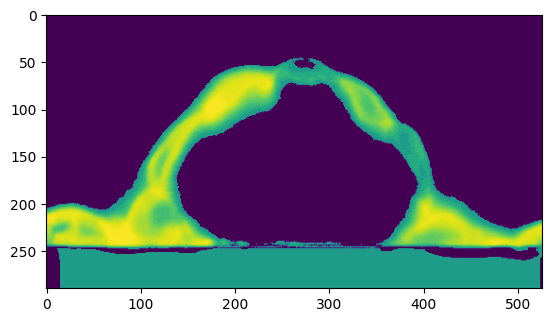

In [728]:
plt.imshow(equalized_image[400])

In [786]:
dotter_2D = dotim(image=clahe_image, is2D=False)
mask_clh = dotter_2D.get_mask(times=2, binshape=(2,2,2), v='+')
# dots_clh = dotter_2D.conv_deconv(times=2, binshape=(2,2,2), v='+')

Convolving: 1/2
Convolving: 2/2
Deconvolving: 2/2
Deconvolving: 1/2


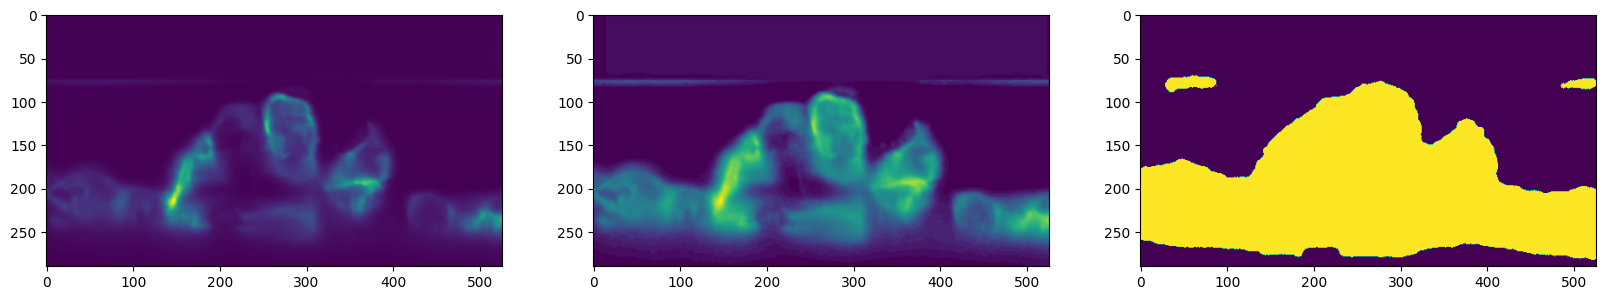

In [821]:
y = 124
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image[y])
plt.subplot(132)
plt.imshow(clahe_image[y])
plt.subplot(133)
plt.imshow(mask_clh[y])

In [822]:
masked_image = mask_clh*image

In [823]:
import tifffile as tiff
tiff.imwrite('./../ppujol/dome_clahe_xMask_62_2.tif', normalize_image(masked_image, 255).astype(np.uint16), imagej=True)

In [579]:
dotter = dotim(image=image, is2D=False)
mask_dotamine = dotter.get_mask(times=3, binshape=(2,2,2), v='+')

Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


In [580]:
dots_dotamine = dotter.conv_deconv(times=3, binshape=(2,2,2), v='+')

Convolving: 1/3
Convolving: 2/3
Convolving: 3/3
Deconvolving: 3/3
Deconvolving: 2/3
Deconvolving: 1/3


In [581]:
mask = copy(mask_dotamine)

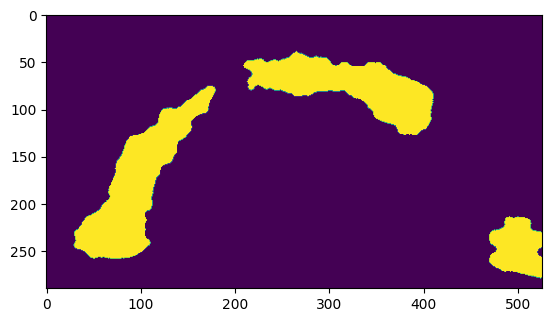

In [659]:
plt.imshow(mask[300])

In [301]:
def normalize_image(im, mult_factor = 1):
    norm_im = (im - im.min()) / (im.max()-im.min()) * mult_factor
    return norm_im

In [303]:
import tifffile as tiff
# tiff.imwrite('./../ppujol/cellMembrane/mask_62_2.tif', mask.astype(np.uint16), imagej=True)

In [ ]:
## Convex hull
# hull_first_nonzero_indices = []
# x = np.arange(1, len(first_nonzero_indices[0]) + 1)

## Convex hull scipy
# for y in first_nonzero_indices:
#     points = np.column_stack((x, y+np.random.normal(0, 0.01, len(y))))
#     hull = ConvexHull(points)

#     unique_x_values, indices = np.unique(points[:, 0], return_index=True)
#     # Find the minimum y-value for each unique x-value in the convex hull
#     min_y_values = np.zeros_like(unique_x_values, dtype=float)
#     for i, x_value in enumerate(unique_x_values):
#         mask_hull = (points[hull.vertices, 0] == x_value)

#         if np.any(mask_hull):
#             min_y_values[i] = np.min(points[hull.vertices][mask_hull, 1])
#         else:
#             min_y_values[i] = np.nan
    
#     # Interpolate missing values
#     nan_indices = np.isnan(min_y_values)
#     min_y_values[nan_indices] = np.interp(unique_x_values[nan_indices], unique_x_values[~nan_indices], min_y_values[~nan_indices])

#     hull_first_nonzero_indices.append(min_y_values)
## FI







# first_nonzero_indices = np.array(hull_first_nonzero_indices)
# first_nonzero_indices = first_nonzero_indices.astype(int)




# ## Convex hull skimage
# big_mask = []
# for i in top_mask:
#     chull = convex_hull_image(i)
#     big_mask.append(chull)
# ## FI


In [467]:
def top_line_image(closed_mask, moveLine = 0, line = False):

    ## Find the top line of the mask
    closed_mask = np.array(closed_mask)
    first_nonzero_indices = np.argmax(closed_mask != 0, axis=1)

    if line == True:
        return first_nonzero_indices

    ## Move up or down the line
    first_nonzero_indices = first_nonzero_indices - moveLine # Units to move the line. If > 0  the line will be lower, useful to get the basal? If < 0 the line will be higher, useful for apical.
    first_nonzero_indices[first_nonzero_indices < 0] = 0
    first_nonzero_indices[first_nonzero_indices >= closed_mask.shape[1]] = closed_mask.shape[1]-1
    ## Fi move up or down the line

    top_mask = np.zeros_like(closed_mask)
    top_mask[np.arange(closed_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(closed_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask
    top_mask[:,0,:] = 0

    return top_mask

def image_from_line(first_nonzero_indices, size):
    
    # print(first_nonzero_indices)

    first_nonzero_indices[first_nonzero_indices < 0] = 0

    top_mask = np.zeros(size)
    first_nonzero_indices[first_nonzero_indices >= top_mask.shape[1]] = top_mask.shape[1]-1
    top_mask[np.arange(top_mask.shape[0])[:, None, None], first_nonzero_indices[:, None, :], np.arange(top_mask.shape[2])] = 1 # Top mask is a 3D array that contains the top line of the actual mask
    top_mask[:,0,:] = 0

    return top_mask


def bresenham_line(x1, y1, x2, y2):
    points = []

    dx = abs(x2 - x1)
    dy = abs(y2 - y1)

    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1

    error = dx - dy

    x, y = x1, y1

    while True:
        points.append((x, y))

        if x == x2 and y == y2:
            break

        e2 = 2 * error

        if e2 > -dy:
            error -= dy
            x += sx

        if e2 < dx:
            error += dx
            y += sy

    return points

In [532]:
mask = mask.astype(np.uint8)

closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

top_mask = top_line_image(closed_mask)

top_line_y = top_line_image(closed_mask, line=True)

all_smooth_line = []


n = 0
frame = -1

for line in top_line_y:


    new_line = copy(line)

    differences = np.diff(line)
    indices = np.where(abs(differences) > 20)[0] # Threshold of differences
    print(indices) if n == frame else None


    max_before = len(new_line)-1
    max_after = 0

    for index in indices:

        print(index) if n == frame else None

        if index >= max_before and index <= max_after:
            
            continue

        for i in range(index - 1, -1, -1):
            max_before = index - 1
            if differences[i] < 0 and line[i] != 0:
                max_before = i
                break

        for i in range(index, len(differences)):
            max_after = index + 1
            if differences[i] > 0 and line[i] != 0:
                max_after = i + 1  # Adjusting for the 0-based index
                break
    
        print(max_before, '-->', line[max_before], max_after, '-->', line[max_after]) if n == frame else None

        bresenham_line_fix = list(bresenham_line(max_before, line[max_before], max_after, line[max_after]))

        for x,y in bresenham_line_fix:

            new_line[x] = y
    
    all_smooth_line.append(new_line)

    n += 1

    # break
            
all_smooth_line = np.array(all_smooth_line)

top_mask_2 = image_from_line(all_smooth_line, mask.shape)


# top_mask = top_mask.astype(np.float64)

# filtered = gaussian_filter(top_mask, 20) # 30 for a 500 tall pixel image
# epithelial = filtered*image

[  0   1   2   3   4   5  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 187
 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205
 206 219 220 221 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 344 345 346 347 348 349 350 351 352 353 354
 355 356 357 358 359 360 361 362 363 364 365 385 386 387 388 389 390 391
 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409
 410 411 412 413 414 415 416 417 418 419] [  6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25 

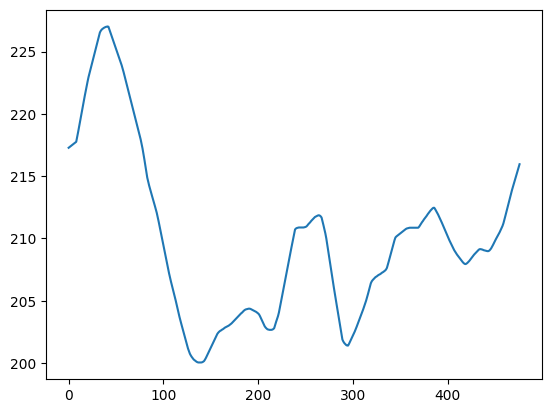

In [576]:
mask = mask.astype(np.uint8)

closed_mask = []
for i in mask:
    full = cv2.morphologyEx(i, cv2.MORPH_CLOSE, np.ones((15, 15)))
    closed_mask.append(full)

top_mask = top_line_image(closed_mask)

# ## Convex hull skimage
# big_mask = []
# for i in top_mask:
#     chull = convex_hull_image(i)
#     big_mask.append(chull)
# ## FI

top_line_y = top_line_image(closed_mask, line=True)


def moving_average(arr, window_size):
    window = np.ones(window_size) / window_size
    return np.convolve(arr, window, mode='valid')

def find_crossovers(fast_ma, slow_ma):
    # Determine the length of the longer array
    max_len = max(len(fast_ma), len(slow_ma))

    # Pad both arrays to have the same length
    fast_ma_padded = np.pad(fast_ma, (0, max_len - len(fast_ma)), 'constant', constant_values=np.nan)
    slow_ma_padded = np.pad(slow_ma, (0, max_len - len(slow_ma)), 'constant', constant_values=np.nan)

    # Identify indices where crossovers occur
    crossover_up = np.where(fast_ma_padded > slow_ma_padded)[0]
    crossover_down = np.where(fast_ma_padded < slow_ma_padded)[0]

    return crossover_up, crossover_down


for line in top_line_y:

    clusters = []
    current_cluster = []

    for value in line:
        if value == 0:
            current_cluster.append(value)
        elif current_cluster:
            clusters.append(current_cluster)
            current_cluster = []

    if current_cluster:
        clusters.append(current_cluster)
    

    differences = np.diff(line)
    indices = np.where(abs(differences) > 10)[0] # Threshold of differences

    # print(indices)


    fast_ma = moving_average(line, 5)
    slow_ma = moving_average(line, 50)

    crossover_up, crossover_down = find_crossovers(fast_ma, slow_ma)

    print(crossover_up, crossover_down)

    plt.plot(slow_ma)


    break


    # break


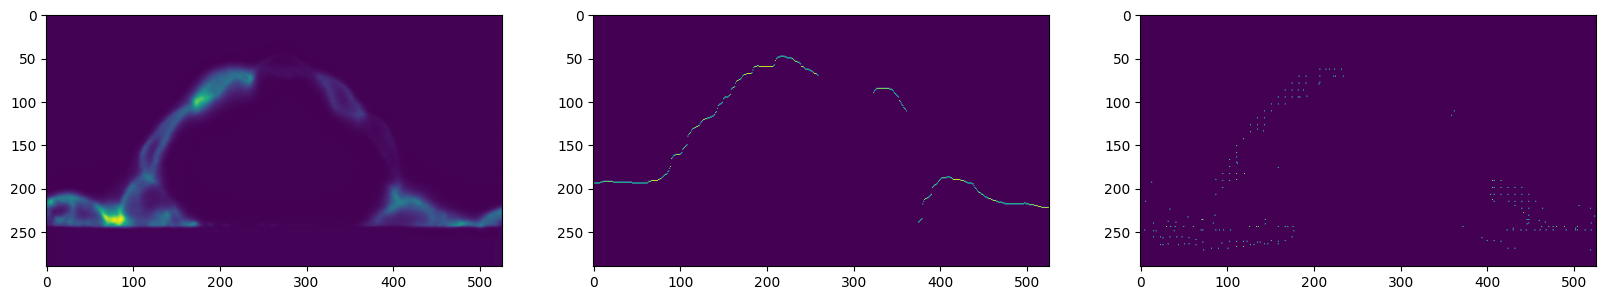

In [582]:
y = 400
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.imshow(image[y])
plt.subplot(132)
plt.imshow(top_mask[y])
plt.subplot(133)
plt.imshow(dots_dotamine[y])

# Epithelial Save

In [353]:
import tifffile as tiff
tiff.imwrite('./../ppujol/cellMembrane/top_mask_hull_2_62_2.tif', normalize_image(top_mask, 255).astype(np.uint16), imagej=True)

In [369]:
def shape_finder_2D(height_mask):

    angles = [i for i in range(-60, 60+1, 10)]

    total_cell_mask = np.zeros(shape=(height_mask.shape))

    for angle in angles:

        ## Rotate the masked image.        
        rot_height_mask = rotate(height_mask, angle, reshape=False) # Be careful of the reshape=False
        # cell_top_mask_rot = rotate(height_matrix, angle)

        ## Find the border of the cell which is the maximum of this masked image.
        cell_border = []

        ## Get the position of the maximum intensity.
        for i in range(rot_height_mask.shape[1]):
            col = rot_height_mask[:, i]
            max_pos = np.argmax(col == max(col))
            # max_pos = find_first_local_max(col)
            if max_pos <= len(col)-200:
                cell_border.append(max_pos) # Search for the first max
            else:
                cell_border.append('-')

        ## Put the positions in a matrix as we have done with the smoothed line before.
        cell_top_mask_rot = np.zeros_like(rot_height_mask)
        for i in range(cell_top_mask_rot.shape[1]):
            if cell_border[i] != '-':
                cell_top_mask_rot[cell_border[i], i] = 1

        ## Rotate the matrix to have it horizontal as the original image.
        cell_top_mask_rot = rotate(cell_top_mask_rot, -angle, reshape=False)
        cell_top_mask_rot[cell_top_mask_rot < 0] = 0
        total_cell_mask += cell_top_mask_rot

    return np.array(total_cell_mask)

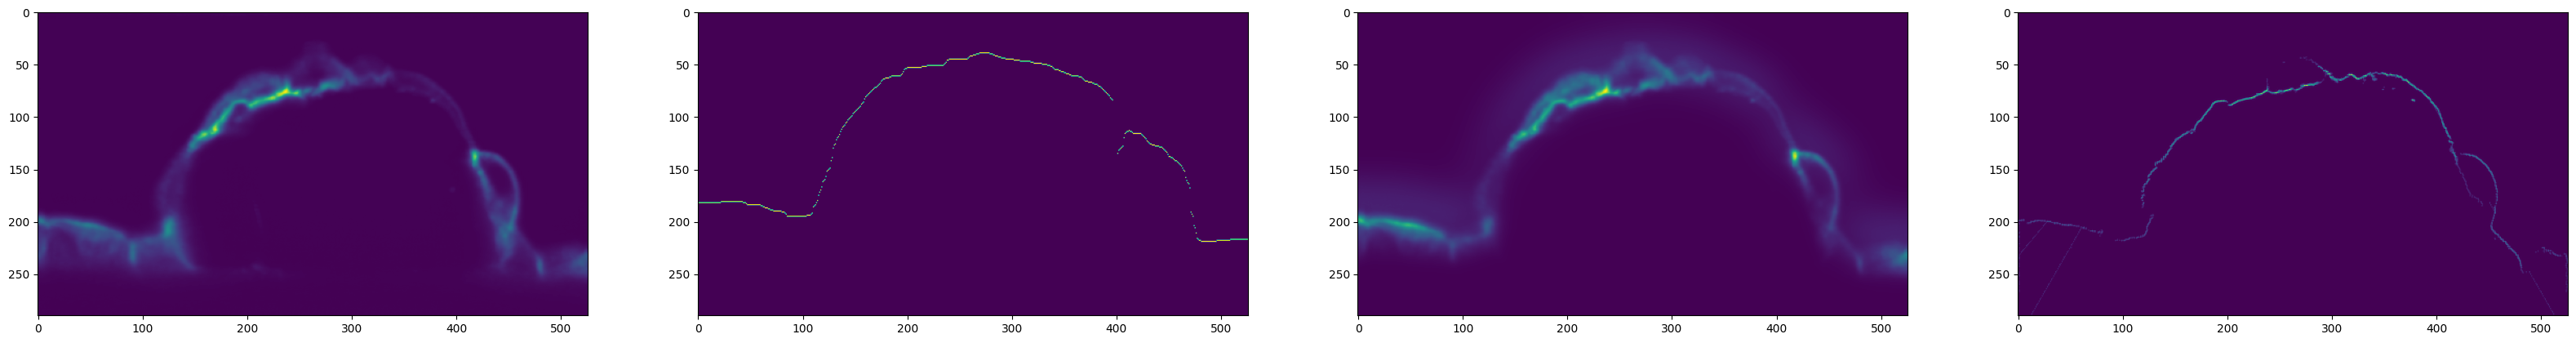

In [370]:
y = 200
plt.figure(figsize=(40,20))
plt.subplot(141)
plt.imshow(image[y])
plt.subplot(142)
# plt.imshow(filtered[y])
plt.imshow(top_mask[y])
plt.subplot(143)
plt.imshow(epithelial[y])
plt.subplot(144)
plt.imshow(shape_finder_2D(epithelial[y]))

In [85]:
epithelial_shape = []
for i in range(epithelial.shape[0]):
    epithelial_shape.append(shape_finder_2D(epithelial[i]))
    print(f'{i+1}/{epithelial.shape[0]}', end='\r')
epithelial_shape = np.array(epithelial_shape)

epithelial_rot = np.transpose(epithelial, axes=(2,1,0))

epithelial_rot_shape = []
for i in range(epithelial_rot.shape[0]):
    epithelial_rot_shape.append(shape_finder_2D(epithelial_rot[i]))
    print(f'{i+1}/{epithelial_rot.shape[0]}', end='\r')
epithelial_rot_shape = np.array(epithelial_rot_shape)

epithelial_rot_shape = np.transpose(epithelial_rot_shape, axes=(2,1,0))

In [86]:
total_epithelial_shape = epithelial_shape + epithelial_rot_shape

# Dots save

In [234]:
import tifffile as tiff
tiff.imwrite('./../ppujol/cellMembrane/total_epithelial_shape_62_2.tif', total_epithelial_shape.astype(np.uint16), imagej=True)

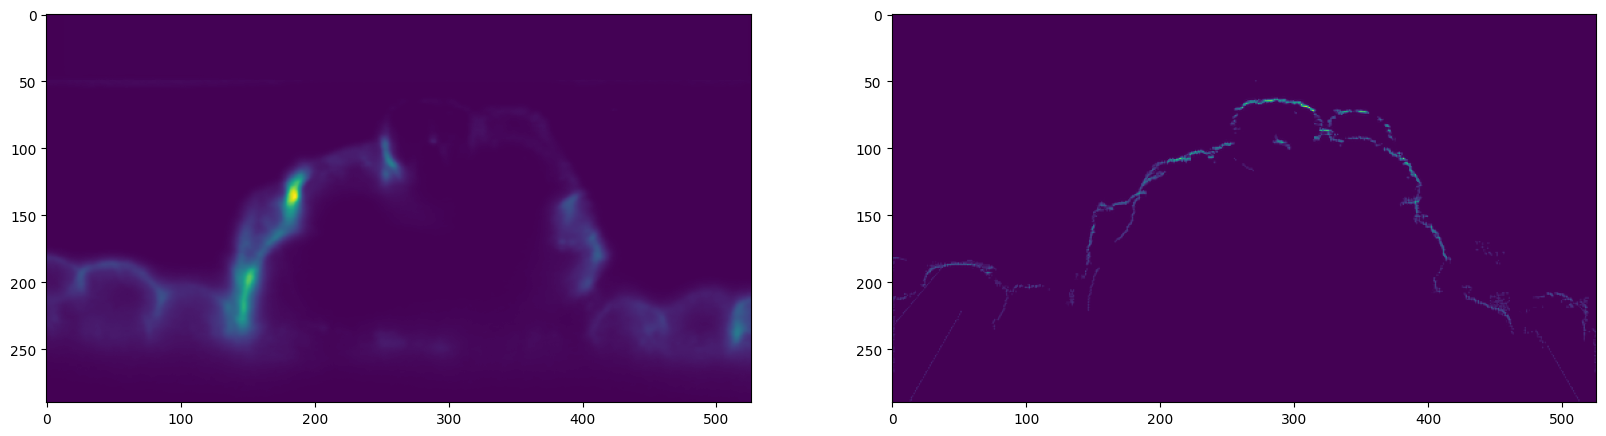

In [372]:
layer = 150
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(image[layer])
plt.subplot(122)
plt.imshow(total_epithelial_shape[layer]*100)

In [229]:
def connect_close_dots(matrix, dot_radius=3, structure_size=1):
    binary_matrix = matrix > 0.3  # Convert the matrix to binary

    # Use distance transform to create a mask for connecting close dots
    distance_transform = distance_transform_edt(binary_matrix)
    close_dots_mask = distance_transform < dot_radius

    # Use binary closing to connect close dots
    closed_matrix = binary_closing(close_dots_mask, structure=np.ones((structure_size, structure_size)))

    # Use binary opening to remove small objects (sparse dots)
    processed_matrix = binary_opening(closed_matrix, structure=np.ones((structure_size, structure_size)))

    return matrix * processed_matrix


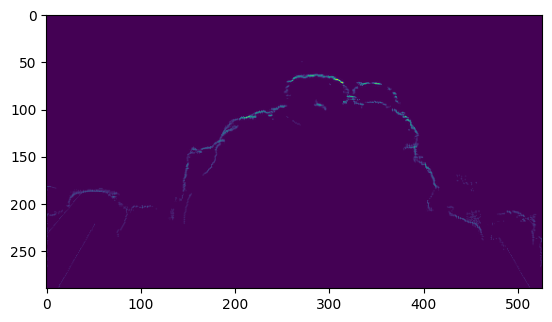

In [230]:
plt.imshow(connect_close_dots(total_epithelial_shape[layer], dot_radius=5, structure_size=1))

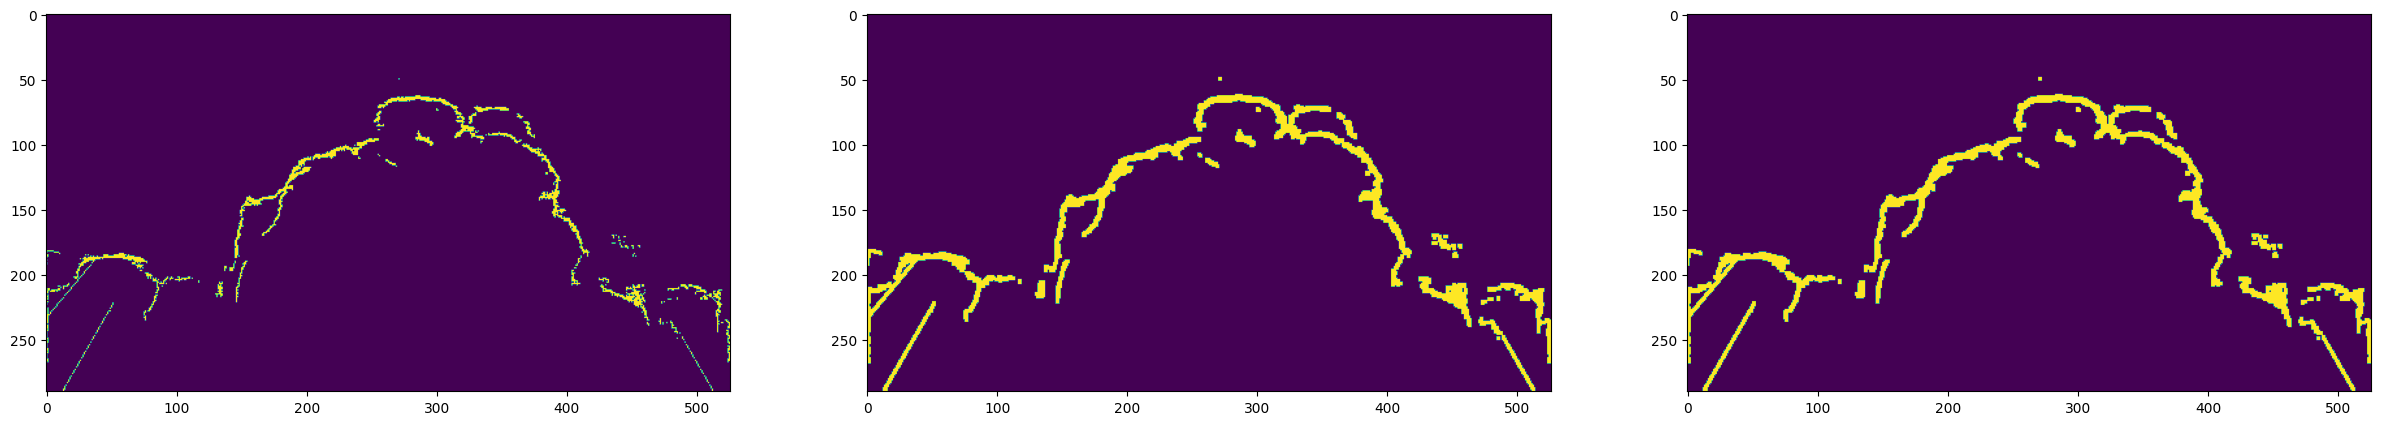

In [231]:
binary_matrix = total_epithelial_shape[layer] > 0.3
plt.figure(figsize=(30,30))
plt.subplot(131)
plt.imshow(binary_matrix)
plt.subplot(132)
edited = binary_dilation(binary_matrix, generate_binary_structure(2,2), iterations=1)
plt.imshow(edited)
plt.subplot(133)
# edited = binary_erosion(edited, generate_binary_structure(2,2), iterations=1)
plt.imshow(edited)


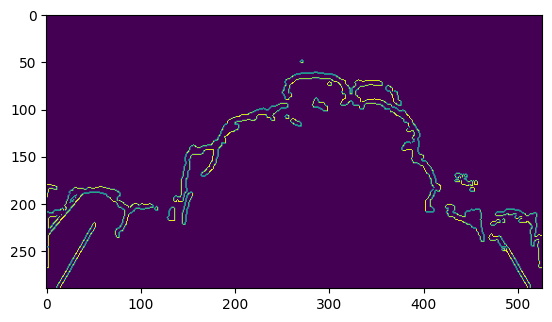

In [232]:
edited = edited.astype(np.uint8)
edges = cv2.Canny(edited, 1, 5, apertureSize=3)
plt.imshow(edges)
lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 10, minLineLength=100, maxLineGap=5)


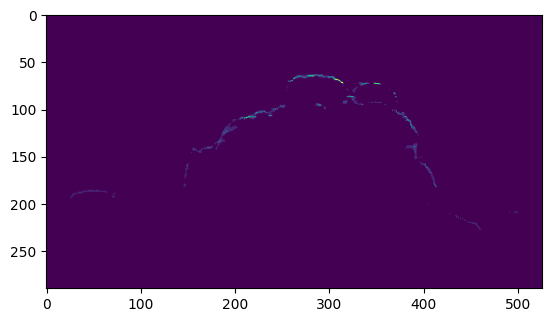

In [233]:
def apply_bilateral_filter(img):
    # The second parameter is the filter diameter, controlling the size of the neighborhood used for filtering.
    # The third parameter is the sigma values, controlling the standard deviation for color space and coordinate space.
    filtered_img = cv2.bilateralFilter(img, d=0, sigmaColor=2, sigmaSpace=2)
    return filtered_img

filtered_img = apply_bilateral_filter(total_epithelial_shape[layer].astype(np.uint8))

plt.imshow(filtered_img)